In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn import linear_model, preprocessing, cross_validation, neighbors
from sklearn.metrics import confusion_matrix
%matplotlib inline
sns.set_style('white')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv('creditcard.csv')

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

For preprocessing, let's check for Class Imbalance

In [54]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

Look at that. Even if we predict a 0 across the board we'll still get over a 99.8% accuracy rating. That model won't do at all. We have to scale back our sampling of 0 Status observations by about 99% so that we are left with a balance of 0 and 1 observations. 

In [55]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df.Class==0]
df_minority = df[df.Class==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=492,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.Class.value_counts()

1    492
0    492
Name: Class, dtype: int64

In [56]:
df_downsampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 984 entries, 143480 to 281674
Data columns (total 31 columns):
Time      984 non-null float64
V1        984 non-null float64
V2        984 non-null float64
V3        984 non-null float64
V4        984 non-null float64
V5        984 non-null float64
V6        984 non-null float64
V7        984 non-null float64
V8        984 non-null float64
V9        984 non-null float64
V10       984 non-null float64
V11       984 non-null float64
V12       984 non-null float64
V13       984 non-null float64
V14       984 non-null float64
V15       984 non-null float64
V16       984 non-null float64
V17       984 non-null float64
V18       984 non-null float64
V19       984 non-null float64
V20       984 non-null float64
V21       984 non-null float64
V22       984 non-null float64
V23       984 non-null float64
V24       984 non-null float64
V25       984 non-null float64
V26       984 non-null float64
V27       984 non-null float64
V28       984 non-n

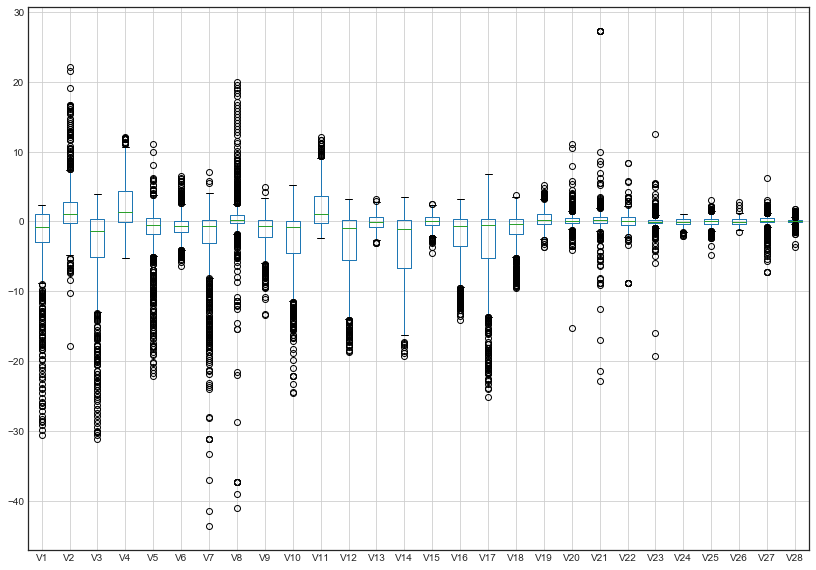

In [71]:
df2 = df_downsampled.drop(['Time', 'Amount', 'Class'], 1)
fig, ax = plt.subplots(figsize = (14,10))
df2.boxplot()

Much better for class imbalance. unfortunately we had to lose so much our data. As we can see above, there are still some outliers in the features. But we ahve already scaled back our data so much that to remove any more (particularly when none of the outliers are especially skewed) would only degrade our model. Let's run a few models on this new dataset and see how well we can predict defaults.

In [57]:
# Separate input features (X) and target variable (y)
y = df_downsampled.Class
X = df_downsampled.drop('Class', axis=1)

# KNN

In [49]:
# X = np.array(df1.drop(['Class'], 1))
# y = np.array(df1['Class'])

In [58]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y,test_size=0.2)

In [59]:
clf = neighbors.KNeighborsClassifier()
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [60]:
accuracy = clf.score(X_test, y_test)

In [61]:
print(accuracy)

0.6345177664974619


63.45% isn't really very good considering we know we have a 50/50 split on 0 and 1 observations. Of course, now that we've reduced our observations so much we aren't worried about the computational cost of running a couple of other models. Let's try out a Logistic Regression. 

# LOGISTIC REGRESSION

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf_2 = LogisticRegression().fit(X, y)
pred_y_2 = clf_2.predict(X)
 
# Is our model still predicting just one class?
print( np.unique( pred_y_2 ) )
 
# How's our accuracy?
print( accuracy_score(y, pred_y_2) )

[0 1]
0.9359756097560976


That's an accuracy score we can feel much better about. Good at predicting without being so accurate as to suggest overfitting. 

# RANDOM FOREST

In [17]:
from sklearn import tree, ensemble
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, cross_val_score

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)
print("Training size: {}: Test Size: {}".format(len(X_train), len(X_test)))

Training size: 787: Test Size: 197


In [64]:
rfc = ensemble.RandomForestClassifier()
cross_val_score(rfc, X_train, y_train, cv=10)

array([0.93670886, 0.97468354, 0.92405063, 0.91139241, 0.94936709,
       0.93670886, 0.92405063, 0.91025641, 0.93589744, 0.92307692])

In [67]:
rfc = ensemble.RandomForestClassifier()
cross_val_score(rfc, X_test, y_test, cv=5)

array([0.9       , 0.925     , 0.8974359 , 0.94871795, 0.94871795])

The random forest is also very accurate. Though not seen here, I ran each cross validation (5 & 10) several times. They varied between 89% and 100%. Obviously 100% indicates overfitting usually. But with such a small quantity of observations it is quite possible for a single fold to come back with a perfect score. 

Just the same, In this case I think the Logistic Regression is the best model for the predictions. I would suggest that whomever is providing the data focus more attention on bulking up the number of default observations so that we can train our model in a more thorough manner. 